

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Practical Assignment 3
    <br>
     Hidden Markov Models -Bayes Net <br>
<font color=696880 size=4>
Amirardalan Dehghanpour


# HMM Assignment

 –Sequence Modeling with Hidden Markov Models (HMM)

## Part 1: HMM Models


Introduce the concept of Hidden Markov Models (HMMs) and their applications in sequence modeling.

### -What is an HMM?
A Hidden Markov Model is a statistical model that represents systems with:
1. **Hidden states** – not directly observable (e.g., phonemes, weather conditions, gene regions).
2. **Observable outputs** – emitted signals or features (e.g., audio features, weather observations).

### - Key Components of an HMM:
- **States (Z)**: Hidden variables (e.g., phonemes in speech recognition).
- **Observations (X)**: Observable features (e.g., MFCCs from audio).
- **Initial Probabilities (π)**: Probability of starting in a particular state.
- **Transition Probabilities (A)**: Probability of moving from one state to another.
- **Emission Probabilities (B)**: Probability of observing a value given a state.

### -HMM Process Overview:
At each time step `t`, the system:
1. Transitions from one state to another using **transition probability A**
2. Emits an observation using **emission probability B**

### - Why Use HMMs?
HMMs are useful for modeling sequential data where the underlying structure is hidden but can be inferred from observations.

#### Example Applications:
- **Speech Recognition** – Infer phonemes from audio features
- **Natural Language Processing** – POS tagging, named entity recognition
- **Bioinformatics** – Identify coding vs. non-coding DNA regions
- **Finance** – Regime detection in time series

---

 In this part, we will:
- Work with dna datasets
- Extract HMM parameters from data
- Implement HMM algorithms from scratch
- Visualize results to understand hidden sequences



## Part 2: Extract HMM Parameters from DNA Dataset ##

In this section, you'll use a labeled DNA dataset to extract the core parameters of a Hidden Markov Model:
- **Initial Probabilities** – likelihood of starting in a specific hidden state
- **Transition Matrix** – probabilities of switching from one hidden state to another
- **Emission Matrix** – probabilities of emitting a specific observation given the hidden state

We are given labeled sequences of DNA nucleotides with associated hidden states (`Coding` or `NonCoding`). Using this, we can compute the HMM parameters as follows:


####  Initial Probabilities (π)
- For each sequence, check the **first position** (Position == 1).
- Count how many times each hidden state appears at the start.
- Normalize the counts to get the starting probability distribution.

####  Transition Probabilities (A)
- For each sequence, look at every **pair of consecutive states** (from Position _t_ to _t+1_).
- Count how often each transition occurs (e.g., Coding → Coding, Coding → NonCoding).
- For each state, normalize its outgoing transition counts to sum to 1.

####  Emission Probabilities (B)
- For each state, count how frequently it emits each nucleotide (A, C, G, T).
- Normalize these counts within each state.

This method is based on **maximum likelihood estimation(MLE)** using frequency counts, which is valid because we have access to the true hidden states.
These parameters will be used in later for performing inference (Forward/Viterbi).



 ## Load the Dataset ##

In [1775]:
# Load the synthetic DNA dataset
import pandas as pd
import numpy as np

# Load dataset 
dna_data = pd.read_csv("dna_dataset.csv")

# Preview the data
print(dna_data.head())
print(dna_data['State'].value_counts())


   Sequence_ID  Position Nucleotide      State
0            1         1          A     Coding
1            1         2          G  NonCoding
2            1         3          G     Coding
3            1         4          A  NonCoding
4            1         5          T     Coding
State
Coding       30705
NonCoding    29295
Name: count, dtype: int64


## Identify Unique States and Observations ##

In [1776]:
states = dna_data['State'].unique()
observations = dna_data['Nucleotide'].unique()
print("States:", states)
print("Observations:", observations)

States: ['Coding' 'NonCoding']
Observations: ['A' 'G' 'T' 'C']


## Estimate Initial Probabilities (π) ##

In [1777]:
# Compute the probability of starting in each state.
# This is based on the first position of each sequence in the dataset.


start_states = dna_data[dna_data['Position'] == 1]['State']


start_counts = start_states.value_counts().reindex(states, fill_value=0)

initial_probs = (start_counts / start_counts.sum()).to_dict()

print("Initial Probabilities (π):", initial_probs)


Initial Probabilities (π): {'Coding': 0.49, 'NonCoding': 0.51}


## Estimate Transition Probabilities (A) ##

In [1778]:
# Compute the probability of transitioning from one hidden state to another.
# Based on how states change within each sequence.

# Step 1: Initialize transition counts
transition_counts = {from_state: {to_state: 0 for to_state in states} for from_state in states}

# Step 2: Group by sequence and count transitions
for seq_id, group in dna_data.groupby('Sequence_ID'):
    states_seq = group.sort_values('Position')['State'].values
    for i in range(len(states_seq) - 1):
        from_state = states_seq[i]
        to_state = states_seq[i + 1]
        transition_counts[from_state][to_state] += 1

# Step 3: Normalize the transition counts to get probabilities
transition_probs = {}
for from_state, to_counts in transition_counts.items():
    total = sum(to_counts.values())
    if total > 0:
        transition_probs[from_state] = {to_state: count / total for to_state, count in to_counts.items()}
    else:
        transition_probs[from_state] = {to_state: 0.0 for to_state in to_counts}

# Print result
print("Transition Probabilities (A):")
for from_state, to_probs in transition_probs.items():
    print(from_state, "→", to_probs)


Transition Probabilities (A):
Coding → {'Coding': 0.4450775142440705, 'NonCoding': 0.5549224857559295}
NonCoding → {'Coding': 0.5823615160349854, 'NonCoding': 0.4176384839650146}


## Estimate Emission Probabilities (B) ##

In [1779]:
# Compute the probability of emitting a given nucleotide from each hidden state.
# Based on how frequently each nucleotide appears for a given state.

# Step 1: Initialize emission counts
emission_counts = {state: {obs: 0 for obs in observations} for state in states}

# Step 2: Count emissions for each (state, observation) pair
for _, row in dna_data.iterrows():
    state = row['State']
    obs = row['Nucleotide']
    emission_counts[state][obs] += 1

# Step 3: Normalize the counts to get probabilities
emission_probs = {}
for state, obs_counts in emission_counts.items():
    total = sum(obs_counts.values())
    if total > 0:
        emission_probs[state] = {obs: count / total for obs, count in obs_counts.items()}
    else:
        emission_probs[state] = {obs: 0.0 for obs in obs_counts}

# Print result
print("Emission Probabilities (B):")
for state, probs in emission_probs.items():
    print(state, "→", probs)


Emission Probabilities (B):
Coding → {'A': 0.2556261195245074, 'G': 0.24950333821853118, 'T': 0.2441947565543071, 'C': 0.2506757857026543}
NonCoding → {'A': 0.35343915343915344, 'G': 0.1501962792285373, 'T': 0.3484212322922, 'C': 0.14794333504010923}


## Part 4: Forward Algorithm (Filtering with Elapse Time + Observation)

The **Forward Algorithm** helps us compute the probability of an observation sequence in a Hidden Markov Model (HMM). It also gives us the belief about the system's hidden state at each time step.

To do this, it recursively applies two updates at each time step `t`:


###  Step 1: Elapse Time (Prediction)
Predict the probability of being in each hidden state at time `t`, before seeing the new observation:

$$
P(x_t | e_{1:t-1}) = \sum_{x_{t-1}} P(x_t | x_{t-1}) \cdot P(x_{t-1} | e_{1:t-1})
$$

This uses the **transition probabilities (A)** and previous beliefs.


###  Step 2: Observation Update (Bayesian Update)
Once we see the new observation `e_t`, we update our beliefs:

$$
P(x_t | e_{1:t}) \propto P(e_t | x_t) \cdot P(x_t | e_{1:t-1})
$$

This uses the **emission probabilities (B)** and normalizes the result.


### Final Result:
- We maintain a belief `α_t(x)` for each state `x` at every time step.
- We can compute the total probability of the sequence by summing the final α values.



In [1780]:
def elapse_time(prior, transition_probs, states):
    """
    Predicts the belief at time t using the belief at time t-1 and transition matrix A.

    Parameters:
    - prior: dict of P(state at t-1 | evidence up to t-1)
    - transition_probs: dict of dicts P(to_state | from_state)
    - states: list of possible states

    Returns:
    - prediction: dict of P(state at t | evidence up to t-1)
    """
    prediction = {}

    # Iterate over each state at time t
    for state_t in states:
        # Sum the probabilities of reaching state_t from all possible states at time t-1
        prediction[state_t] = sum(prior[state_t_prev] * transition_probs[state_t_prev].get(state_t, 0)
                                  for state_t_prev in states)

    return prediction


In [1781]:
def observe(predicted, observation, emission_probs, states):
    """
    Updates the belief at time t after seeing observation e_t, using emission matrix B.

    Parameters:
    - predicted: dict of P(state at t | evidence up to t-1)
    - observation: the observed symbol at time t (e.g., 'A')
    - emission_probs: dict of dicts P(obs | state)
    - states: list of possible states

    Returns:
    - updated: dict of P(state at t | evidence up to t)
    """
    updated = {}

    # Step 1: Apply the Bayesian update for each state
    for state in states:
        # Multiply the predicted probability by the emission probability of the observation
        updated[state] = predicted[state] * emission_probs[state].get(observation, 0)
    
    # Step 2: Normalize the updated probabilities to ensure they sum to 1
    total_prob = sum(updated.values())
    if total_prob > 0:
        updated = {state: prob / total_prob for state, prob in updated.items()}
    else:
        updated = {state: 0.0 for state in states}  # In case of zero probability

    return updated



In [1782]:
def forward_algorithm(observation_sequence, states, start_probs, transition_probs, emission_probs):
    """
    Runs the full forward algorithm over an observation sequence.

    Parameters:
    - observation_sequence: list of observations (e.g., ['A', 'C', 'T', ...])
    - states: list of hidden states
    - start_probs: initial state distribution (π)
    - transition_probs: transition matrix A
    - emission_probs: emission matrix B

    Returns:
    - alpha_list: list of belief dicts (α_t) over time
    - sequence_prob: total probability of the full observation sequence
    """
    # Initialize the alpha_list to store the belief at each time step
    alpha_list = []

    # Step 1: Initialization (at time t=1)
    # Initialize the belief for the first observation
    belief = {}
    for state in states:
        belief[state] = start_probs[state] * emission_probs[state].get(observation_sequence[0], 0)

    # Normalize the initial belief
    total_prob = sum(belief.values())
    if total_prob > 0:
        belief = {state: prob / total_prob for state, prob in belief.items()}
    else:
        belief = {state: 0.0 for state in states}

    # Add the initial belief to the alpha_list
    alpha_list.append(belief)

    # Step 2: Recursion (for subsequent time steps t=2 to T)
    for t in range(1, len(observation_sequence)):
        # Step 2.1: Elapse time (prediction)
        prior_belief = alpha_list[-1]  # Belief at time t-1
        predicted_belief = elapse_time(prior_belief, transition_probs, states)

        # Step 2.2: Observation update (Bayesian update)
        observation = observation_sequence[t]
        updated_belief = observe(predicted_belief, observation, emission_probs, states)

        # Add the updated belief at time t to the alpha_list
        alpha_list.append(updated_belief)

    # Step 3: Final probability of the observation sequence
    sequence_prob = sum(alpha_list[-1].values())

    return alpha_list, sequence_prob


In [1783]:
# Small test case
test_sequence = ['A','C','C','T','T','T','A','G']

# Run forward algorithm
alpha_vals, prob = forward_algorithm(
    test_sequence,
    states,
    initial_probs,
    transition_probs,
    emission_probs
)

print(f"\nTotal probability of sequence {test_sequence}: {prob:.6f}")
print("\nBelief at final time step:")
for state, p in alpha_vals[-1].items():
    print(f"P({state}) = {p:.4f}")



Total probability of sequence ['A', 'C', 'C', 'T', 'T', 'T', 'A', 'G']: 1.000000

Belief at final time step:
P(Coding) = 0.6443
P(NonCoding) = 0.3557


## Part 5: Viterbi Algorithm – Most Likely State Sequence

While the Forward Algorithm gives us the probability of a sequence of observations, the **Viterbi Algorithm** answers a different question:

> What is the **most likely sequence of hidden states** that could have generated this observation sequence?



The Viterbi Algorithm is a dynamic programming approach. At each time step `t`, it keeps track of:

- The **highest probability path** to each state.
- A **backpointer** that tells us which state led to that one.

###  Two Main Steps:

1. **Recursion (Forward Pass):**
$$
\delta_t(s) = \max_{s'} [\delta_{t-1}(s') \cdot P(s | s')] \cdot P(obs_t | s)
$$

2. **Backtracking (Backward Pass):**
$$
\text{Backtrace from final best state} \rightarrow \text{recover most likely path}
$$





In [1784]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    """
    Viterbi algorithm to find the most probable sequence of hidden states.

    Parameters:
    - obs: list of observations (e.g., ['A', 'C', 'T', ...])
    - states: list of hidden states (e.g., ['Coding', 'NonCoding'])
    - start_p: initial state probabilities
    - trans_p: transition probability matrix
    - emit_p: emission probability matrix

    Returns:
    - prob: probability of the most likely state sequence
    - path: list of most likely hidden states
    """
    # Step 1: Initialization
    # V[t][state] will store the highest probability of any state sequence that ends with state at time t.
    V = [{}]
    # backpointer[t][state] will store the state at time t-1 that led to the highest probability for state at time t.
    backpointer = [{}]
    
    # Initialization for the first observation
    for state in states:
        V[0][state] = start_p[state] * emit_p[state].get(obs[0], 0)
        backpointer[0][state] = None  # No previous state for the first observation
    
    # Step 2: Recursion (for subsequent time steps)
    for t in range(1, len(obs)):
        V.append({})
        backpointer.append({})
        
        for state in states:
            # Find the maximum probability from the previous states for state at time t
            (max_prob, prev_state) = max(
                [(V[t-1][prev_state] * trans_p[prev_state].get(state, 0) * emit_p[state].get(obs[t], 0), prev_state)
                 for prev_state in states]
            )
            
            V[t][state] = max_prob
            backpointer[t][state] = prev_state  # Store the previous state that led to the optimal path at time t
    
    # Step 3: Termination (find the final state with the highest probability)
    final_state = max(V[len(obs)-1], key=V[len(obs)-1].get)
    prob = V[len(obs)-1][final_state]

    # Step 4: Backtracking (find the best path by backtracking from the final state)
    path = [final_state]
    for t in range(len(obs)-1, 0, -1):
        path.insert(0, backpointer[t][path[0]])  # Add the previous state to the path

    return prob, path


In [1785]:
obs_seq = ['A', 'C', 'G', 'T', 'A','A', 'C', 'C', 'C', 'A']

prob, most_likely_path = viterbi(
    obs_seq,
    states,
    initial_probs,
    transition_probs,
    emission_probs
)

print("Observation sequence:", obs_seq)
print("Most likely state sequence:", most_likely_path)
print("Probability of this path:", prob)



Observation sequence: ['A', 'C', 'G', 'T', 'A', 'A', 'C', 'C', 'C', 'A']
Most likely state sequence: ['NonCoding', 'Coding', 'Coding', 'NonCoding', 'Coding', 'NonCoding', 'Coding', 'Coding', 'Coding', 'NonCoding']
Probability of this path: 5.879383986938688e-09


## Part 6: Visualizing the Most Likely Hidden State Sequence (Viterbi Path)

After using the Viterbi algorithm, we get the **most likely sequence of hidden states** that could have produced the given observations.

In this part, we'll:
1. Visually display the Viterbi path over time.
2. Compare it with the **true hidden state sequence** (if known).
3. Visualize it on top of the **Forward Algorithm belief heatmap**.

This helps understand where the model is confident, where it might be uncertain, and how accurate the predictions are.


In [1786]:
import matplotlib.pyplot as plt

def plot_viterbi_path(viterbi_path, states, title="Viterbi Most Likely Path"):
    """
    Plots the Viterbi path as a timeline of states.

    Parameters:
    - viterbi_path: list of predicted states from Viterbi algorithm
    - states: list of possible hidden states
    - title: the title of the plot (optional, default is "Viterbi Most Likely Path")
    """
    time_steps = range(len(viterbi_path))  # Time steps (index of observations)

    # Mapping states to integers for plotting
    state_to_int = {state: idx for idx, state in enumerate(states)}

    # Convert viterbi path states to integers for y-axis
    state_indices = [state_to_int[state] for state in viterbi_path]

    # Create a plot
    plt.figure(figsize=(10, 6))

    # Plot the Viterbi path as a series of steps (vertical lines)
    plt.step(time_steps, state_indices, where='mid', label="Viterbi Path", color='b', linestyle='-', linewidth=2)

    # Add labels for the states
    plt.yticks(range(len(states)), states)

    # Add titles and labels
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Hidden States")
    plt.grid(True)
    plt.xticks(time_steps)  # Ensure x-axis shows each time step

    plt.show()



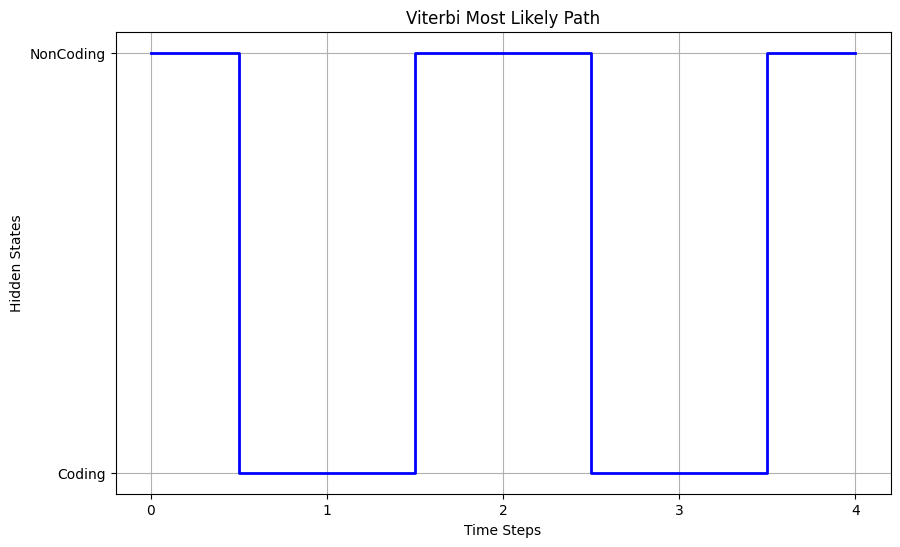

In [1787]:
# Run Viterbi on example observation sequence
obs_seq = ['A', 'C', 'T', 'G', 'A']
prob, viterbi_path = viterbi(obs_seq, states, initial_probs, transition_probs, emission_probs)

# Plot the path
plot_viterbi_path(viterbi_path, states)


# Bayesian Networks

In this assignment, we will work with a Bayesian Network based on a scenario: **a group of friends deciding whether to order pizza** and how that decision, along with other factors, affects their evening satisfaction.

We'll learn how to:
- Represent a Bayesian Network
- Define its conditional probability tables (CPTs)
- Implement inference algorithms

---

## Scenario

Imagine a group of friends planning their evening. They may or may not be hungry. It might be a weekend. These factors influence whether they decide to order pizza. If pizza is ordered **and** friends are free, they might plan a movie night. The presence of a movie night then affects how satisfied they are.

---

## 🔍 Variables

| Variable | Description | Values |
|----------|-------------|--------|
| `H` | It's a hungry day | {True, False} |
| `W` | It's the weekend | {True, False} |
| `P` | They order pizza | {True, False} |
| `F` | Friends are free | {True, False} |
| `M` | Movie night is planned | {True, False} |
| `S` | Satisfaction level | {'high', 'medium', 'low'} |

---

## 🔗 Network Structure

The relationships among the variables and their conditional probablities follow these tables:

### P(H) — Hungry
| H     | P(H) |
|-------|------|
| True  | 0.6  |
| False | 0.4  |

### P(W) — Weekend
| W     | P(W) |
|-------|------|
| True  | 0.3  |
| False | 0.7  |

### P(F) — Friends Free
| F     | P(F) |
|-------|------|
| True  | 0.8  |
| False | 0.2  |

### P(P | H, W) — Pizza
| H     | W     | P(P=True) | P(P=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.95      | 0.05       |
| True  | False | 0.7       | 0.3        |
| False | True  | 0.5       | 0.5        |
| False | False | 0.1       | 0.9        |

### P(M | P, F) — Movie Night
| P     | F     | P(M=True) | P(M=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.9       | 0.1        |
| True  | False | 0.4       | 0.6        |
| False | True  | 0.6       | 0.4        |
| False | False | 0.2       | 0.8        |

### P(S | M) — Satisfaction
| M     | S        | P(S)   |
|-------|----------|--------|
| True  | high     | 0.7    |
|       | medium   | 0.25   |
|       | low      | 0.05   |
| False | high     | 0.1    |
|       | medium   | 0.3    |
|       | low      | 0.6    |




###  Step 1: Define and Visualize the Bayesian Network
#### Your task in this step:
##### 1. Draw the Bayesian Network using networkx and matplotlib
##### 2. Create a dictionary called `bayes_net` that stores all variables, their parents, and their CPTs

In [1788]:
import networkx as nx
import matplotlib.pyplot as plt

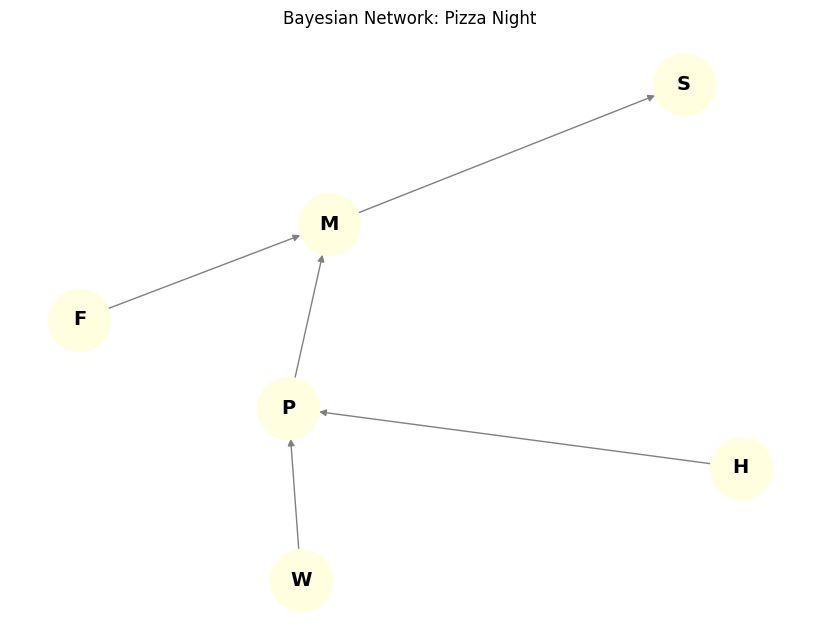

0.7


In [1789]:
# --- TODO: Draw the graph ---

# Create a directed graph to represent the Bayesian Network
G = nx.DiGraph()

# Add edges based on the Pizza Night Bayes Net
# Define the dependencies (edges)
G.add_edge('H', 'P')  # H -> P
G.add_edge('W', 'P')  # W -> P
G.add_edge('P', 'M')  # P -> M
G.add_edge('F', 'M')  # F -> M
G.add_edge('M', 'S')  # M -> S

# Plot the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)  # Set seed for reproducible layout
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightyellow',
        font_size=14, edge_color='gray', font_weight='bold', arrows=True)
plt.title("Bayesian Network: Pizza Night")
plt.show()

# --- TODO: Define the Bayesian Network as a dictionary ---

bayes_net = {
    'H': {
        'values': [True, False],
        'parents': [],
        'cpt': {
            True: 0.6,
            False: 0.4
        }
    },
    'W': {
        'values': [True, False],
        'parents': [],
        'cpt': {
            True: 0.3,
            False: 0.7
        }
    },
    'F': {
        'values': [True, False],
        'parents': [],
        'cpt': {
            True: 0.8,
            False: 0.2
        }
    },
    'P': {
        'values': [True, False],
        'parents': ['H', 'W'],
        'cpt': {
            (True, True): {True: 0.95, False: 0.05},
            (True, False): {True: 0.7, False: 0.3},
            (False, True): {True: 0.5, False: 0.5},
            (False, False): {True: 0.1, False: 0.9}
        }
    },
    'M': {'values': [True, False],
        'parents': ['P', 'F'],
        'cpt': {
            (True, True): {True: 0.9, False: 0.1},
            (True, False): {True: 0.4, False: 0.6},
            (False, True): {True: 0.6, False: 0.4},
            (False, False): {True: 0.2, False: 0.8}
        }
    },
    'S': {'values': ['high', 'medium', 'low'],
        'parents': ['M'],
        'cpt': {
            True: {'high': 0.7, 'medium': 0.25, 'low': 0.05},
            False: {'high': 0.1, 'medium': 0.3, 'low': 0.6}
        }
    }
}

# --- Helper Function: Get Probability based on Evidence ---

def get_prob(var, value, evidence, bayes_net):
    """
    Return the probability of var = value given evidence,
    based on the structure and CPTs in the bayes_net dictionary.
    """
    node = bayes_net[var]
    parents = node['parents']
    cpt = node['cpt']

    # Case when there are no parents (direct probability)
    if not parents:
        return cpt[value]
    else:
        # Build the key for the CPT based on the evidence
        try:
            if len(parents) == 1:
                key = evidence[parents[0]]
            else:
                key = tuple(evidence[parent] for parent in parents)
        except KeyError as e:
            raise ValueError(f"Missing parent '{e.args[0]}' for variable '{var}' in evidence.")

        # Return the probability for the given value
        return cpt[key][value]

# Test the function with the query: What is P(P=True | H=True, W=False)?
print(get_prob('P', True, {'H': True, 'W': False}, bayes_net))


# Step 2: Inference by Enumeration

In this step, you'll implement **exact inference** in a Bayesian Network using the **enumeration algorithm**.

---

##  Goal :

We want to compute the probability of a **query variable** given some **evidence**.  
For example:

$$
P(S = \text{high} \mid H = \text{True}, W = \text{True})
$$

To do this, we'll use:

1. **A recursive function `enumerate_all`**  
   - Loops through all hidden variables and sums over them
   - Multiplies conditional probabilities using the Bayesian Network

2. **A main function `query_enum`**  
   - Computes the numerator: probability of the query value given evidence
   - Computes the denominator: normalization over all possible values of the query variable
   - Returns the final **normalized probability**

---






In [1790]:
variables = ['H', 'W', 'F', 'P', 'M', 'S']  # Must be topological order



def enumerate_all(vars_left, evidence, bayes_net):
    """Exact recursive enumeration matching textbook algorithm."""
    if not vars_left:
        return 1.0
    
    current_var = vars_left[0]
    node = bayes_net[current_var]
    
    if current_var in evidence:
        # Observed variable path
        value = evidence[current_var]
        prob = get_prob(current_var, value, evidence, bayes_net)
        return prob * enumerate_all(vars_left[1:], evidence, bayes_net)
    else:
        # Sum over all possible values
        total = 0.0
        # Determine possible values dynamically
        if not node['parents']:
            possible_values = [True, False] if isinstance(node['cpt'], (int, float)) else list(node['cpt'].keys())
        else:
            first_parent_combo = next(iter(node['cpt']))
            prob_entry = node['cpt'][first_parent_combo]
            possible_values = [True, False] if isinstance(prob_entry, (int, float)) else list(prob_entry.keys())
        
        for val in possible_values:
            new_evidence = evidence.copy()
            new_evidence[current_var] = val
            prob = get_prob(current_var, val, new_evidence, bayes_net)
            total += prob * enumerate_all(vars_left[1:], new_evidence, bayes_net)
        return total

def query_enum(query_var, query_val, evidence, bayes_net):
    """Exact query answering matching mathematical formulation."""
    # Check if query_var is already in evidence
    if query_var in evidence:
        return 1.0 if evidence[query_var] == query_val else 0.0
    
    # Calculate P(query_val, evidence)
    evidence_with_query = evidence.copy()
    evidence_with_query[query_var] = query_val
    numerator = enumerate_all(variables, evidence_with_query, bayes_net)
    
    # Calculate P(evidence)
    denominator = 0.0
    # Get possible values for query variable
    query_node = bayes_net[query_var]
    if not query_node['parents']:
        possible_values = [True, False] if isinstance(query_node['cpt'], (int, float)) else list(query_node['cpt'].keys())
    else:
        first_parent_combo = next(iter(query_node['cpt']))
        prob_entry = query_node['cpt'][first_parent_combo]
        possible_values = [True, False] if isinstance(prob_entry, (int, float)) else list(prob_entry.keys())
    
    for val in possible_values:
        evidence_with_val = evidence.copy()
        evidence_with_val[query_var] = val
        denominator += enumerate_all(variables, evidence_with_val, bayes_net)
    
    return numerator / denominator if denominator > 0 else 0.0

In [1791]:
#  Example: P(S='high' | H=True, W=True)

result = query_enum('S', 'high', {'H': True, 'W': True}, bayes_net)
print(f"P(S = 'high' | H=True, W=True) = {result:.4f}")


P(S = 'high' | H=True, W=True) = 0.5716


#  Step 3: Inference with Variable Elimination

In this step, you will implement **inference using Variable Elimination** — an exact, more efficient alternative to Enumeration.

---

## Core Ideas:

- Instead of computing the full joint distribution, we work with **factors**.
- A factor is a table mapping variable assignments to probabilities.
- We **join factors** together (multiplication).
- We **eliminate hidden variables** (sum them out).
- At the end, we normalize the final factor.

---

## Inputs
- `query_var`: The variable we're asking about (e.g. `'S'`)
- `query_val`: The value we want (e.g. `'high'`)
- `evidence`: Observed variables
- `bayes_net`: The full Bayesian Network

---

## What You’ll Implement
1. **Factor Construction**: Build initial factors from CPTs.
2. **Restrict for Evidence**: Incorporate evidence early by pruning CPTs.
3. **Join**: Combine factors that mention the same variable.
4. **Eliminate**: Marginalize out variables not in the query or evidence.
5. **Normalize**: Get valid probability distribution.

---



In [1792]:
def make_factor(var, bayes_net, evidence):
    node = bayes_net[var]
    parents = node['parents']
    all_vars = parents + [var]
    domains = [bayes_net[v]['values'] for v in all_vars]
    table = {}

    for assignment in product(*domains):
        assign_dict = dict(zip(all_vars, assignment))

        # Skip inconsistent evidence
        if any(evidence.get(v) is not None and evidence[v] != val for v, val in assign_dict.items()):
            continue

        # Extract CPT probability
        if parents:
            parent_vals = tuple(assign_dict[p] for p in parents) if len(parents) > 1 else assign_dict[parents[0]]
            prob = node['cpt'][parent_vals][assign_dict[var]]
        else:
            prob = node['cpt'][assign_dict[var]]

        key = tuple(assign_dict[v] for v in all_vars)
        table[key] = prob

    return {'vars': all_vars, 'table': table}

def join_factors(f1, f2):
    vars_all = list(dict.fromkeys(f1['vars'] + f2['vars']))
    domains = [bayes_net[v]['values'] for v in vars_all]
    table = {}

    for assignment in product(*domains):
        assign_dict = dict(zip(vars_all, assignment))
        try:
            a1 = tuple(assign_dict[v] for v in f1['vars'])
            a2 = tuple(assign_dict[v] for v in f2['vars'])
            p = f1['table'][a1] * f2['table'][a2]
            table[tuple(assign_dict[v] for v in vars_all)] = p
        except KeyError:
            continue

    return {'vars': vars_all, 'table': table}

def eliminate(var, factor):
    var_idx = factor['vars'].index(var)
    new_vars = [v for v in factor['vars'] if v != var]
    domains = [bayes_net[v]['values'] for v in new_vars]
    table = {}

    for assignment in product(*domains):
        prob_sum = 0
        for val in bayes_net[var]['values']:
            full_assignment = list(assignment)
            full_assignment.insert(var_idx, val)
            prob_sum += factor['table'].get(tuple(full_assignment), 0)
        table[assignment] = prob_sum

    return {'vars': new_vars, 'table': table}

def query_ve(query_var, query_val, evidence, bayes_net):
    # Step 1: Build initial factors
    factors = [make_factor(var, bayes_net, evidence) for var in bayes_net]

    # Step 2: Eliminate hidden variables
    hidden_vars = [v for v in bayes_net if v not in evidence and v != query_var]

    for var in hidden_vars:
        relevant = [f for f in factors if var in f['vars']]
        if not relevant:
            continue
        new_factor = relevant[0]
        for f in relevant[1:]:
            new_factor = join_factors(new_factor, f)
        reduced = eliminate(var, new_factor)
        factors = [f for f in factors if f not in relevant]
        factors.append(reduced)

    # Step 3: Join remaining factors
    result = factors[0]
    for f in factors[1:]:
        result = join_factors(result, f)

    # Step 4: Normalize
    query_idx = result['vars'].index(query_var)
    dist = {}
    for k, v in result['table'].items():
        key = k[query_idx]
        dist[key] = dist.get(key, 0) + v

    total = sum(dist.values())
    if total == 0:
        return 0.0
    return dist.get(query_val, 0) / total


In [1793]:
# Test: What is P(S='high' | H=True, W=True)?
result_ve = query_ve('S', 'high', {'H': True, 'W': True}, bayes_net)
print(f"P(S = 'high' | H=True, W=True) = {result_ve:.4f}")

P(S = 'high' | H=True, W=True) = 0.5716



## Compare Enumeration vs. Variable Elimination
Explain your answer in each question
1. Do both methods return the **same probability** for your chosen query and evidence? Why or why not?
بله زیرا در هیچ کدام از روش ها تقریبی استفاده نکردیم و به طور دقیق مقادیر را حساب کردیم.

2. Which method was **faster** in your tests? Provide the execution times.
we expect elimination to be faster but here because of small size of bayes_net it may not show differences.

3. Why is **Variable Elimination** usually more efficient than Enumeration, especially for larger networks?
چون هیچوقت جدولی که همه متغیر ها در آن حضور داشته باشند نخواهیم داشت که این جلوی بزرگ شدن جداول به صورت نمایی را میگیرد و در عوض وقتی جدول جدیدی میسازیم که از چند متغیر استفاده میکند در مرحله بعد یک جمع کردن داریم که حداقل یکی از متغیر ها را کم میکند.
4. Can you think of a scenario where Enumeration might be **simpler or more appropriate** to use than VE?
در حالت هایی که اندازه شبکه بیز کوچک باشد یا در حالتی که همه احتمالات مشترک را بخواهیم و فقط به یک استنتاج خاص نیاز نداشته باشیم
5. What would happen to the performance of each method if the number of variables doubled? Try to explain without coding it.
enumeration: exp in the number of variables and this is for binary variables and if size of variables is doubeled runtime gets 2^n times bigger

VE:  it is polynomial it tree-width d is tree width and runtime is n.k^d and when size of variables is doubled runtime is doubled too.

# Step 4: Approximate Inference with Sampling

In this part, you'll implement two approximate inference algorithms:
- **Rejection Sampling**
- **Likelihood Weighting**

These methods generate random samples from the Bayesian Network to estimate conditional probabilities.

---

##  Rejection Sampling

- Sample all variables from the prior distribution.
- **Reject** any sample that does not match the evidence.
- Among accepted samples, estimate the query probability.


---

##  Likelihood Weighting

- Sample variables in topological order.
- For **evidence variables**, **fix** their value and assign a **weight** equal to the likelihood of observing that value.
- For non-evidence variables, sample normally.
- Compute a weighted average of the query variable.

---

##  Your Tasks

Implement the following:
- `rejection_sampling(query_var, query_val, evidence, bayes_net, N)`
- `likelihood_weighting(query_var, query_val, evidence, bayes_net, N)`


In [1794]:
import random

# === STEP 4: Approximate Inference with Sampling ===
# ---------------------------------------------------

# Rejection Sampling ---
def rejection_sampling(query_var, query_val, evidence, bayes_net, N=1000):
    samples = []
    
    for _ in range(N):
        sample = prior_sample(bayes_net)
        # Only keep samples consistent with evidence
        if all(sample[var] == val for var, val in evidence.items()):
            samples.append(sample)
    
    if not samples:
        return 0.0
    
    # Now, among accepted samples, compute how many match query
    matches = sum(1 for sample in samples if sample[query_var] == query_val)
    
    return matches / len(samples)



# Likelihood Weighting ---
def likelihood_weighting(query_var, query_val, evidence, bayes_net, N=1000):
    weighted_sum = 0.0
    total_weight = 0.0
    for _ in range(N):
        sample, weight = weighted_sample(bayes_net, evidence)
        if sample[query_var] == query_val:
            weighted_sum += weight
        total_weight += weight
    if total_weight == 0:
        return 0
    return weighted_sum / total_weight
# Prior Sampling Helper (for Rejection Sampling) ---
def prior_sample(bayes_net):
    sample = {}
    for var in bayes_net:
        node = bayes_net[var]
        parents = node['parents']
        if not parents:
            dist = node['cpt']
        else:
            key = tuple(sample[parent] for parent in parents) if len(parents) > 1 else sample[parents[0]]
            dist = node['cpt'][key]
        
        # Now sample from dist properly
        values, probs = zip(*dist.items())  # unzip keys and probabilities
        sampled_value = random.choices(values, weights=probs)[0]
        sample[var] = sampled_value
    return sample

# Weighted Sampling Helper (for Likelihood Weighting)
def weighted_sample(bayes_net, evidence):
    sample = {}
    weight = 1.0
    for var in bayes_net:
        node = bayes_net[var]
        parents = node['parents']
        if not parents:
            dist = node['cpt']
        else:
            key = tuple(sample[parent] for parent in parents) if len(parents) > 1 else sample[parents[0]]
            dist = node['cpt'][key]

        if var in evidence:
            sample[var] = evidence[var]
            weight *= dist.get(evidence[var], 0)
        else:
            values, probs = zip(*dist.items())
            sampled_value = random.choices(values, weights=probs)[0]
            sample[var] = sampled_value
    return sample, weight


In [1795]:
evidence = {'H': True, 'W': True}
query = ('S', 'high')

res_reject = rejection_sampling(*query, evidence, bayes_net, N=10000)
res_lw = likelihood_weighting(*query, evidence, bayes_net, N=10000)

print(f"Rejection Sampling:      P(S='high' | H=True, W=True) ≈ {res_reject:.4f}")
print(f"Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ {res_lw:.4f}")


Rejection Sampling:      P(S='high' | H=True, W=True) ≈ 0.5618
Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ 0.5754


In [1796]:
print("🔍 Testing Inference Methods with Various Queries:\n")

queries = [
    # Format: (query_var, query_val, evidence)
    ('P', True, {'H': True, 'W': True}),
    ('P', True, {'H': False, 'W': False}),
    ('M', True, {'H': True, 'W': True}),
    ('M', False, {'F': False, 'P': False}),
    ('S', 'high', {'H': True, 'W': True}),
    ('S', 'low', {'H': False, 'W': False}),
]

for (q_var, q_val, evidence) in queries:
    print(f" Query: P({q_var} = {q_val} | {evidence})")

    # Enumeration
    res_enum = query_enum(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Enumeration:         {res_enum:.4f}")

    # Variable Elimination
    res_ve = query_ve(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Variable Elimination:{res_ve:.4f}")

    # Rejection Sampling
    res_reject = rejection_sampling(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Rejection Sampling:  {res_reject:.4f}")

    # Likelihood Weighting
    res_lw = likelihood_weighting(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Likelihood Weighting:{res_lw:.4f}")

    print("-" * 60)


🔍 Testing Inference Methods with Various Queries:

 Query: P(P = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.9500
  ➤ Variable Elimination:0.9500
  ➤ Rejection Sampling:  0.9570
  ➤ Likelihood Weighting:0.9530
------------------------------------------------------------
 Query: P(P = True | {'H': False, 'W': False})
  ➤ Enumeration:         0.1000
  ➤ Variable Elimination:0.1000
  ➤ Rejection Sampling:  0.1181
  ➤ Likelihood Weighting:0.0992
------------------------------------------------------------
 Query: P(M = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.7860
  ➤ Variable Elimination:0.7860
  ➤ Rejection Sampling:  0.8122
  ➤ Likelihood Weighting:0.7852
------------------------------------------------------------
 Query: P(M = False | {'F': False, 'P': False})
  ➤ Enumeration:         0.8000
  ➤ Variable Elimination:0.8000
  ➤ Rejection Sampling:  0.8093
  ➤ Likelihood Weighting:0.7959
------------------------------------------------------------
 Query: 